# **Importing libraries**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import os
from typing import Tuple, Dict
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shutil
import random

# **Reading Dataset**

In [ ]:
import os

base_path = "/kaggle/input"
for root, dirs, files in os.walk(base_path):
    print(root)


/kaggle/input
/kaggle/input/OriginalDataset
/kaggle/input/OriginalDataset/ModerateDemented
/kaggle/input/OriginalDataset/NonDemented
/kaggle/input/OriginalDataset/VeryMildDemented
/kaggle/input/OriginalDataset/MildDemented
/kaggle/input/AugmentedAlzheimerDataset
/kaggle/input/AugmentedAlzheimerDataset/ModerateDemented
/kaggle/input/AugmentedAlzheimerDataset/NonDemented
/kaggle/input/AugmentedAlzheimerDataset/VeryMildDemented
/kaggle/input/AugmentedAlzheimerDataset/MildDemented


In [ ]:
dataset_path = "/kaggle/input/AugmentedAlzheimerDataset"
train_path="/kaggle/working/train"
test_path = "/kaggle/working/test"

In [ ]:
#Splitting dataset for test data
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):

        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)


        files = os.listdir(class_path)
        random.shuffle(files)


        test_ratio = 0.1
        test_count = int(len(files) * test_ratio)
        test_files = files[:test_count]
        train_files = files[test_count:]

        for file in test_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(test_class_path, file)
            shutil.copy(src, dst)

        for file in train_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(train_class_path, file)
            shutil.copy(src, dst)

# **Class Distribution**

{'VeryMildDemented': 8064, 'MildDemented': 8064, 'ModerateDemented': 5818, 'NonDemented': 8640}


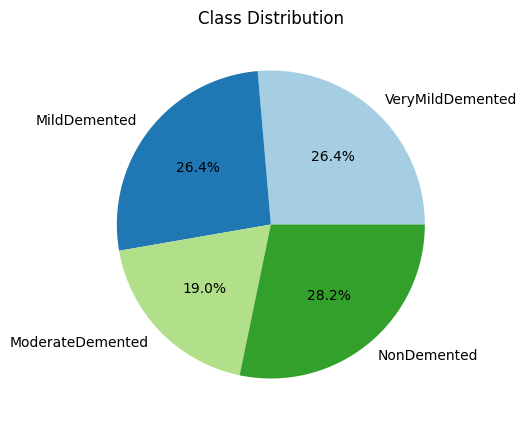

In [ ]:
class_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in os.listdir(train_path)}
print(class_counts)
plt.figure(figsize=(12, 5))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Class Distribution")
plt.show()

# **Splitting Dataset**

In [ ]:
transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = ImageFolder(root=train_path, transform=transform)
val_dataset = ImageFolder(root=test_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

In [ ]:
batch_size=32
learning_rate=0.001
num_epochs=10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader=DataLoader(val_dataset, batch_size=batch_size)
test_loader=DataLoader(test_dataset, batch_size=batch_size)

# **ResNet18 Model**

In [ ]:
class AlzheimerModel(nn.Module): #Model

    def __init__(self, num_classes= 4):
        super().__init__()
        self.weights = torchvision.models.ResNet18_Weights.DEFAULT
        self.model = torchvision.models.resnet18(weights=self.weights)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = AlzheimerModel().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


# **Build Train Function For One Epoch**

In [ ]:
def train_one_epoch() -> Tuple[float, float]:
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss/len(train_loader), 100.*correct/total

In [ ]:
def validate() -> Tuple[float, float]:

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss/len(val_loader), 100.*correct/total

Displaying sample images from the training dataset:


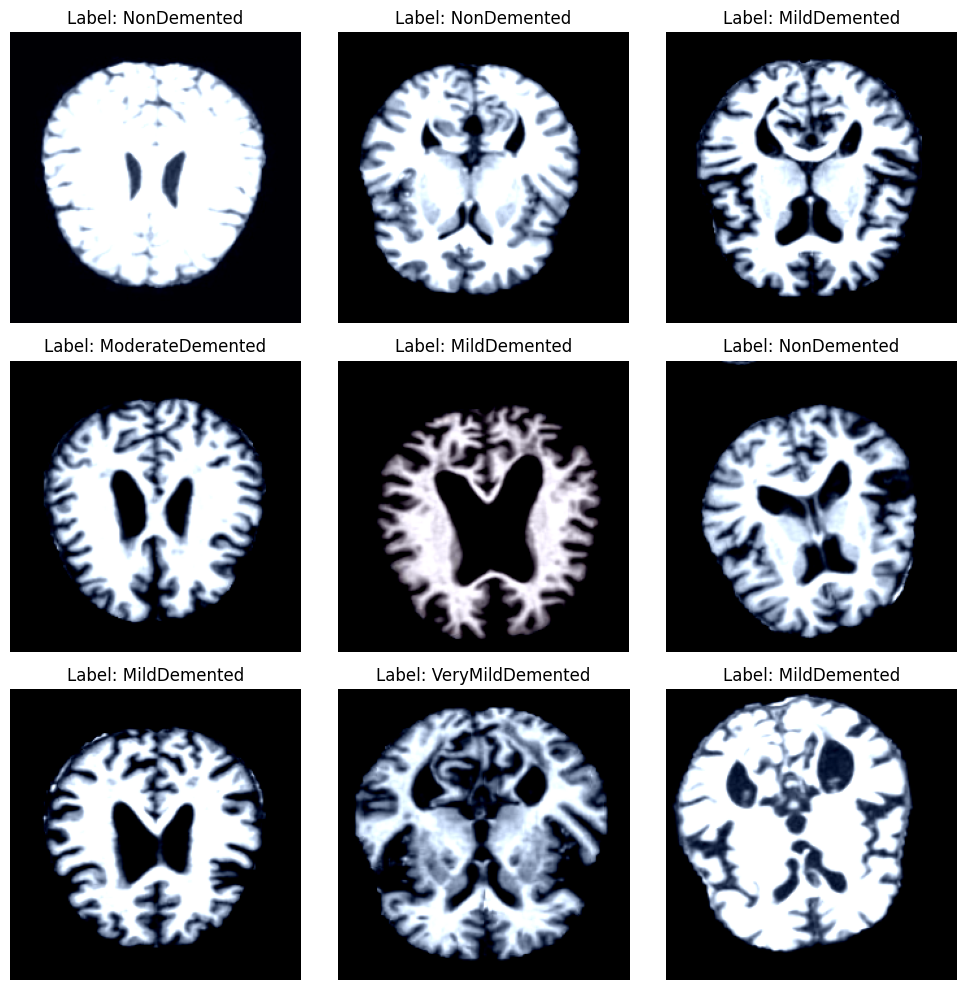

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(data_loader, num_images=9):
    class_names = data_loader.dataset.classes  # Get class names from ImageFolder
    plt.figure(figsize=(10, 10))

    images_shown = 0
    for images, labels in data_loader:
        for i in range(images.size(0)):
            if images_shown >= num_images:
                break
            img = images[i].permute(1, 2, 0).numpy()  # Convert from CHW to HWC
            img = (img * 0.5) + 0.5  # Unnormalize if normalized to [-1, 1]

            ax = plt.subplot(3, 3, images_shown + 1)
            plt.imshow(img)
            plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis("off")
            images_shown += 1
        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()

# Display sample images from the training dataset
print("Displaying sample images from the training dataset:")
show_batch(train_loader)


# **Build Train function**

In [ ]:
def train():
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch()
        val_loss, val_acc = validate()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.model.state_dict(),'/kaggle/working/alzheimer_model.pth')

# **Build Test Function**

In [ ]:
def test():
    model.model.load_state_dict(torch.load('/kaggle/working/alzheimer_model.pth',weights_only=True))
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    class_names = ['Mild', 'Moderate', 'Non Demented', 'Very Mild']

    with torch.no_grad():
        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_loss= running_loss/len(test_loader)
    test_acc = 100.*correct/total

    print(f'\nTest Accuracy: {test_acc:.2f}%')

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
train()

100%|██████████| 956/956 [02:22<00:00,  6.70it/s]


Epoch 1/10:
Train Loss: 0.4802, Train Acc: 79.39%
Val Loss: 0.2974, Val Acc: 88.11%


100%|██████████| 956/956 [02:27<00:00,  6.46it/s]


Epoch 2/10:
Train Loss: 0.1915, Train Acc: 92.74%
Val Loss: 0.2739, Val Acc: 89.26%


100%|██████████| 956/956 [02:27<00:00,  6.47it/s]


Epoch 3/10:
Train Loss: 0.1112, Train Acc: 95.90%
Val Loss: 0.0752, Val Acc: 97.47%


100%|██████████| 956/956 [02:27<00:00,  6.47it/s]


Epoch 4/10:
Train Loss: 0.0767, Train Acc: 97.27%
Val Loss: 0.0595, Val Acc: 97.59%


100%|██████████| 956/956 [02:27<00:00,  6.49it/s]


Epoch 5/10:
Train Loss: 0.0566, Train Acc: 98.05%
Val Loss: 0.0719, Val Acc: 97.70%


100%|██████████| 956/956 [02:27<00:00,  6.50it/s]


Epoch 6/10:
Train Loss: 0.0488, Train Acc: 98.30%
Val Loss: 0.1156, Val Acc: 96.32%


100%|██████████| 956/956 [02:27<00:00,  6.50it/s]


Epoch 7/10:
Train Loss: 0.0427, Train Acc: 98.51%
Val Loss: 0.1540, Val Acc: 95.20%


100%|██████████| 956/956 [02:26<00:00,  6.50it/s]


Epoch 8/10:
Train Loss: 0.0346, Train Acc: 98.74%
Val Loss: 0.0859, Val Acc: 97.26%


100%|██████████| 956/956 [02:27<00:00,  6.48it/s]


Epoch 9/10:
Train Loss: 0.0390, Train Acc: 98.71%
Val Loss: 0.0890, Val Acc: 96.82%


100%|██████████| 956/956 [02:27<00:00,  6.46it/s]


Epoch 10/10:
Train Loss: 0.0280, Train Acc: 99.04%
Val Loss: 0.0910, Val Acc: 97.29%



Test Accuracy: 97.70%

Classification Report:
              precision    recall  f1-score   support

        Mild       0.97      0.99      0.98       896
    Moderate       1.00      1.00      1.00       646
Non Demented       0.98      0.96      0.97       960
   Very Mild       0.96      0.97      0.97       896

    accuracy                           0.98      3398
   macro avg       0.98      0.98      0.98      3398
weighted avg       0.98      0.98      0.98      3398



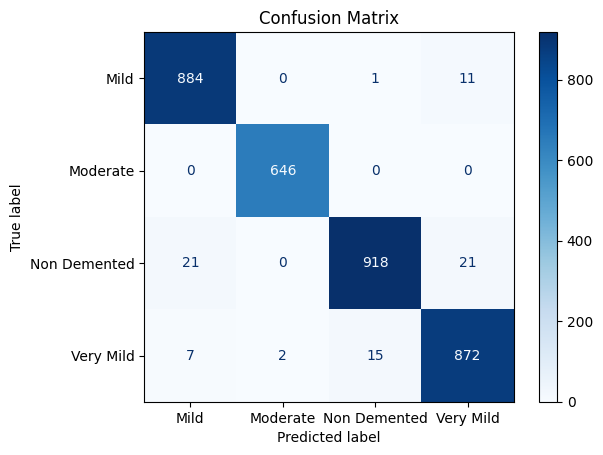

In [ ]:
test()

# **VGG16, EfficientNetB0, InceptionV3, MobileNetV2**

In [ ]:
from torchvision import models
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

models_dict = {}
num_classes = 4
# VGG-16
vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, num_classes)
models_dict["VGG16"] = vgg

# EfficientNet-B0
effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, num_classes)
models_dict["EfficientNetB0"] = effnet

# InceptionV3
inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
inception.fc = nn.Linear(inception.fc.in_features, num_classes)
models_dict["InceptionV3"] = inception

# MobileNetV2
mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, num_classes)
models_dict["MobileNetV2"] = mobilenet



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 210MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 98.8MB/s]
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 178MB/s]  
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 113MB/s]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


# **Confusion Matrix of VGG16, EfficientNetB0, InceptionV3, NobileNetV2**

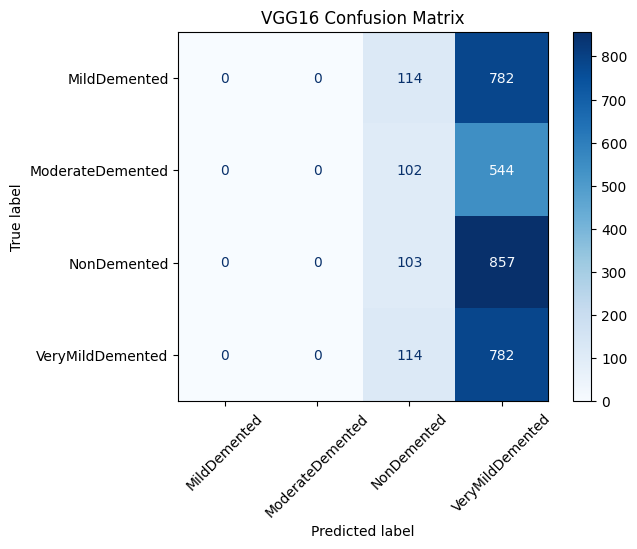

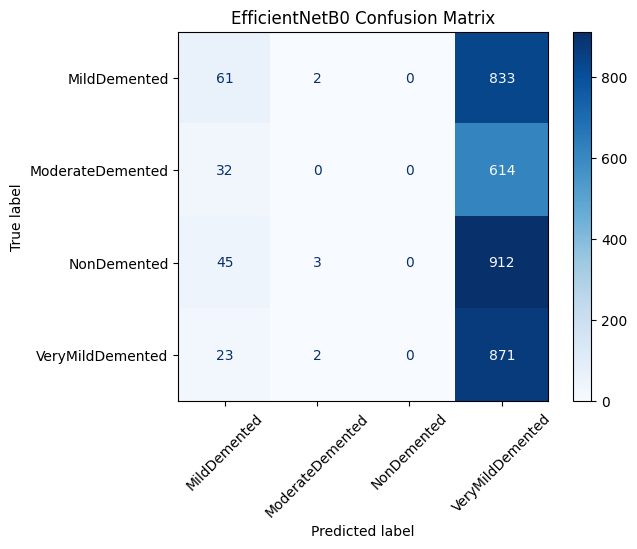

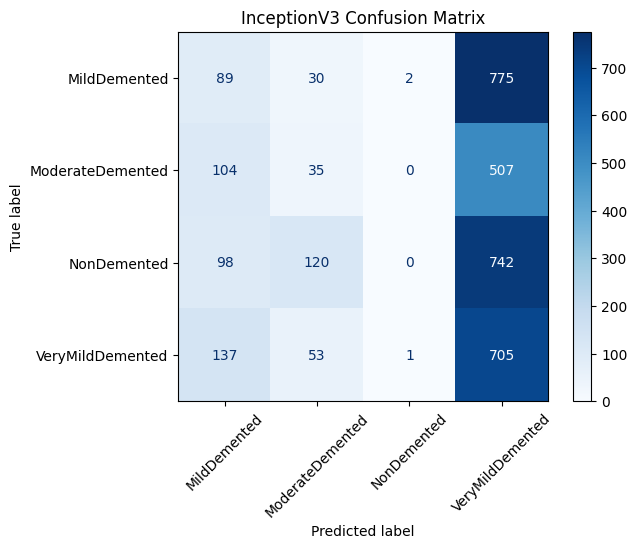

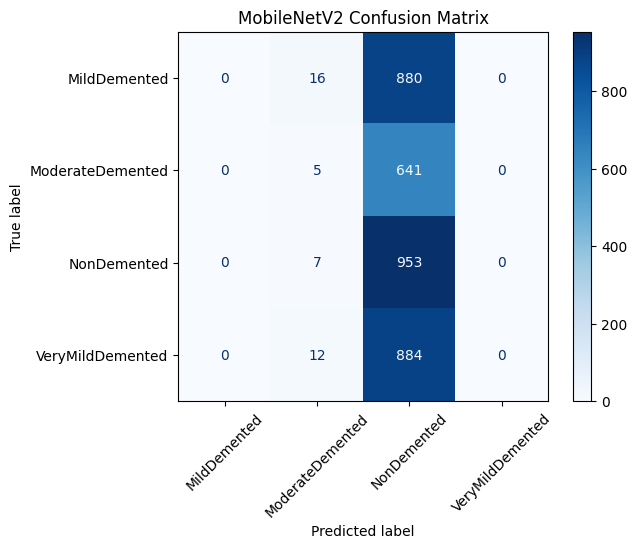

In [ ]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
for model_name, model in models_dict.items():
    model = model.to(device)  # Move model to GPU or CPU as needed
    preds, labels = evaluate_model(model, test_loader, device)
    plot_confusion_matrix(labels, preds, class_names, title=f'{model_name} Confusion Matrix')



In [ ]:
import torch.nn.functional as F

def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # If model returns (main, aux), e.g. InceptionV3
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = F.cross_entropy(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total

    return all_preds, all_labels, accuracy, avg_loss


# **Testing Score**

VGG16 - Test Accuracy: 0.2604, Loss: 1.4130


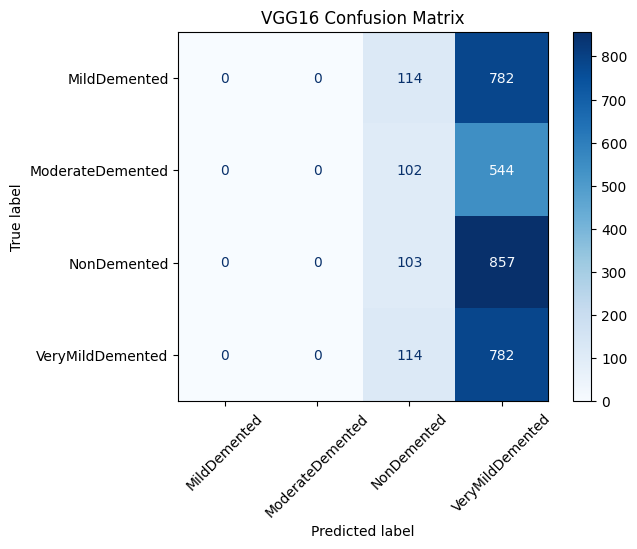

EfficientNetB0 - Test Accuracy: 0.2743, Loss: 1.3845


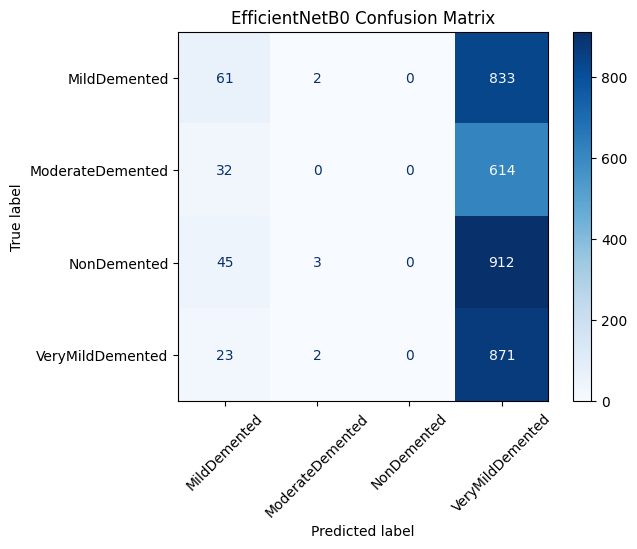

InceptionV3 - Test Accuracy: 0.2440, Loss: 1.4845


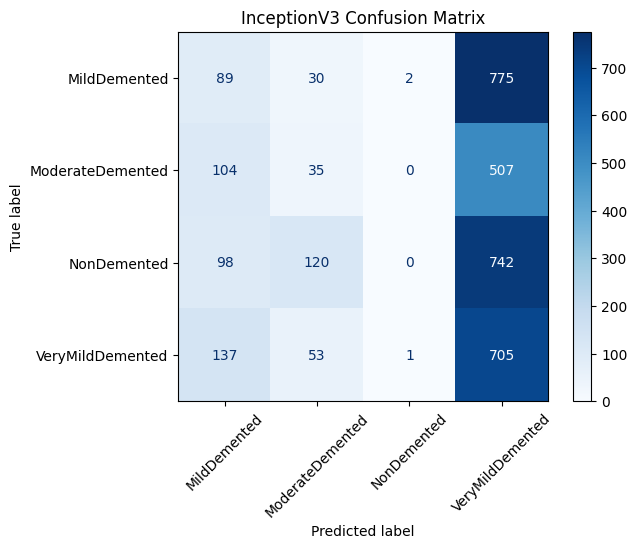

MobileNetV2 - Test Accuracy: 0.2819, Loss: 1.4477


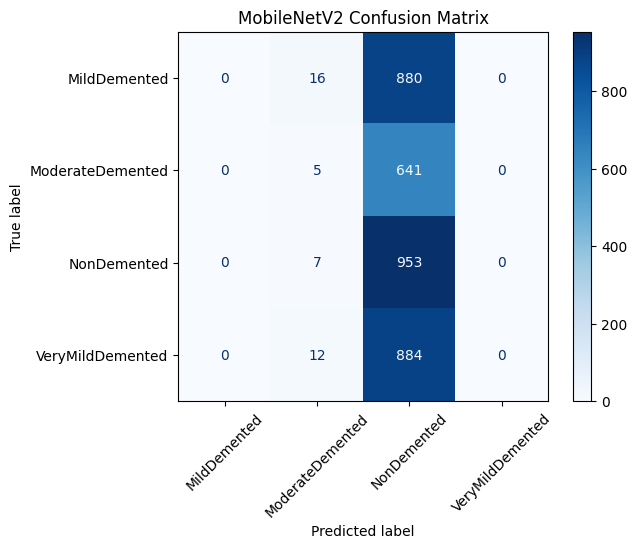

In [ ]:
for model_name, model in models_dict.items():
    preds, labels, acc, loss = evaluate_model(model, test_loader, device)

    print(f'{model_name} - Test Accuracy: {acc:.4f}, Loss: {loss:.4f}')

    plot_confusion_matrix(labels, preds, class_names, title=f'{model_name} Confusion Matrix')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load full dataset
from torch.utils.data import random_split
full_dataset = datasets.ImageFolder(root='/kaggle/input/AugmentedAlzheimerDataset', transform=transform)

# Split into train and validation sets (e.g., 80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Number of classes
num_classes = len(full_dataset.classes)

# **Build Custom CNN**

In [ ]:
import torch
import torch.nn as nn

class CustomCNN50(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN50, self).__init__()

        def conv_block(in_channels, out_channels, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        layers = []
        in_channels = 3
        out_channels_list = [64, 128, 256, 512]
        convs_per_block = [10, 10, 15, 15]  # total 50 conv layers

        for block_idx, out_channels in enumerate(out_channels_list):
            for i in range(convs_per_block[block_idx]):
                stride = 2 if i == 0 else 1  # downsample at start of each block
                layers.append(conv_block(in_channels, out_channels, stride))
                in_channels = out_channels  # update for next layer

        self.features = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(out_channels_list[-1], num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

# Initialize model
model = CustomCNN50(num_classes=4).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Set number of epochs
num_epochs = 10  # You can increase this for better performance

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()               # Zero the parameter gradients
        outputs = model(inputs)             # Forward pass
        loss = criterion(outputs, labels)   # Compute loss
        loss.backward()                     # Backpropagation
        optimizer.step()                    # Update weights

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/10: 100%|██████████| 850/850 [12:57<00:00,  1.09it/s]


Train Loss: 1.3803, Accuracy: 0.2932


Epoch 2/10: 100%|██████████| 850/850 [13:05<00:00,  1.08it/s]


Train Loss: 1.2237, Accuracy: 0.4039


Epoch 3/10: 100%|██████████| 850/850 [13:08<00:00,  1.08it/s]


Train Loss: 0.9342, Accuracy: 0.5629


Epoch 4/10: 100%|██████████| 850/850 [13:09<00:00,  1.08it/s]


Train Loss: 0.8144, Accuracy: 0.6175


Epoch 5/10: 100%|██████████| 850/850 [13:08<00:00,  1.08it/s]


Train Loss: 0.7725, Accuracy: 0.6388


Epoch 6/10: 100%|██████████| 850/850 [13:13<00:00,  1.07it/s]


Train Loss: 0.7281, Accuracy: 0.6631


Epoch 7/10: 100%|██████████| 850/850 [13:12<00:00,  1.07it/s]


Train Loss: 0.6907, Accuracy: 0.6844


Epoch 8/10: 100%|██████████| 850/850 [13:15<00:00,  1.07it/s]


Train Loss: 0.6607, Accuracy: 0.6990


Epoch 9/10: 100%|██████████| 850/850 [13:14<00:00,  1.07it/s]


Train Loss: 0.6128, Accuracy: 0.7226


Epoch 10/10: 100%|██████████| 850/850 [12:55<00:00,  1.10it/s]

Train Loss: 0.5781, Accuracy: 0.7459


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)


# **Evaluating model**

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return all_preds, all_labels, accuracy, avg_loss

# **Validation Score**

In [ ]:
preds, labels, val_acc, val_loss = evaluate_model(model, val_loader, device)
print(f"\nVal Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")


Val Accuracy: 0.7168, Val Loss: 0.6283
